## Step 1: Download images of dinosaurs

In [1]:
!pip install gradio -q

In [2]:
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
import time

In [3]:
def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [4]:
#searches = 'pterodactyl','parasaurolophus','triceratops','brachiosaurus','stegosaurus','trex','Giganotosaurus'
path = Path('dinosaurs')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo',max_images=200))
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

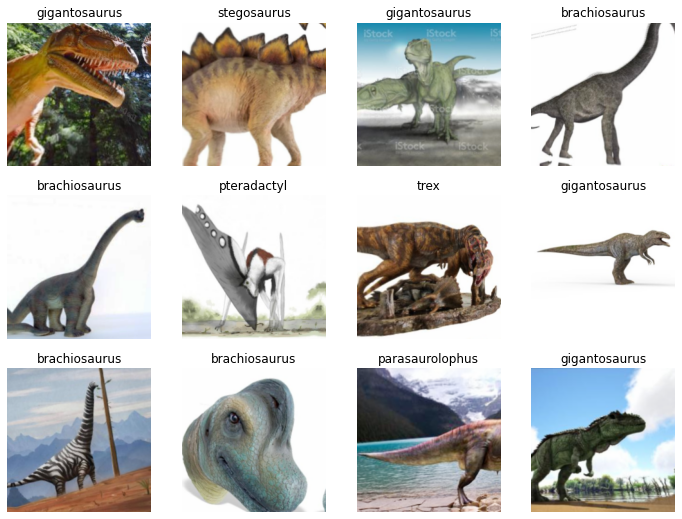

In [5]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256)],
    batch_tfms=aug_transforms(size=224),
).dataloaders(path)

dls.show_batch(max_n=12)

In [6]:
learn = vision_learner(dls, 'seresnext50_32x4d', metrics=error_rate)

In [8]:
#vit_base_patch16_224_miil
#learn = vision_learner(dls, 'seresnext50_32x4d', metrics=error_rate)
#learn.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,2.382311,1.405526,0.438914,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.234153,0.962022,0.303167,00:08
1,1.099688,0.881812,0.294118,00:07
2,0.987133,0.853045,0.253394,00:07
3,0.857848,0.964415,0.276018,00:07
4,0.773988,0.994656,0.276018,00:07
5,0.697529,1.080226,0.285068,00:07
6,0.637822,1.000570,0.271493,00:07
7,0.585805,1.029083,0.262443,00:07
8,0.535863,1.041106,0.257919,00:07
9,0.487678,1.023052,0.257919,00:07


In [7]:
#learn.save('dino2_resnext50')

Path('models/dino2_resnext50.pth')

In [7]:
learn.load('dino2_resnext50')

In [5]:
#learn.fine_tune(10)

In [8]:
img = PILImage.create('brachio.jpg')

In [9]:
def find_character(img):
    character,_,probs = learn.predict(img)
    probs = [o.item() for o in probs]
    return dict(zip(dls.vocab,probs))

In [10]:
find_character(img)

{'brachiosaurus': 0.9992976188659668,
 'gigantosaurus': 0.00011748052202165127,
 'parasaurolophus': 1.1753564876926248e-06,
 'pteradactyl': 1.5328062374919682e-08,
 'stegosaurus': 8.351600513378798e-07,
 'trex': 0.0005086363526061177,
 'triceratops': 7.423329952871427e-05}

In [11]:
EXAMPLES_PATH = Path('examples')

with open('article.md') as f:
    article = f.read()

In [12]:
with open('article.md') as f:
    article = f.read()

In [13]:
interface_options = {
    "title": "Tell me which dinosaur is this?",
    "description": "Prehistoric dinosaurs finder using fastai library deployed on JarvisLabs.ai dashboard by Gradio",
    "examples" : [f'{EXAMPLES_PATH}/{f.name}' for f in EXAMPLES_PATH.iterdir()],
    "article":article,
    "layout": "horizontal",
    #"theme": "default",
    "allow_flagging": "never"
}

In [14]:
import gradio as gr
demo = gr.Interface(fn=find_character, 
                    inputs=gr.inputs.Image(shape=(256, 256)),
                    outputs= gr.outputs.Label(num_top_classes=3), 
                    **interface_options)

if __name__ == "__main__":
    demo.launch(enable_queue=True,server_name="0.0.0.0",server_port=6006)
    #share=True, enable_queue=True

Running on local URL:  http://localhost:6006/

To create a public link, set `share=True` in `launch()`.
